In [25]:
# Библиотеки
import pandas as pd
import numpy as np
import datetime
import requests
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline

from datetime import datetime
from datetime import timedelta
sns.set(style="whitegrid")

In [2]:
# Для начала мы считываем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-kugotov/shared/problem1-reg_data.csv', sep = ';')
df_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-kugotov/shared/problem1-auth_data.csv', sep = ';')

In [3]:
df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
df_1.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
# Меняем timestamp на datetime
df['reg_ts'] = [datetime.fromtimestamp(x) for x in df['reg_ts']]
df_1['auth_ts'] = [datetime.fromtimestamp(x) for x in df_1['auth_ts']]

In [6]:
df.head()

,reg_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2
2,2000-01-14 01:27:27,3
3,2000-05-28 18:19:01,4
4,2000-09-16 15:21:53,5


In [7]:
df_1.head()

,auth_ts,uid
0,1998-11-18 12:43:43,1
1,1999-07-23 02:38:09,2
2,1999-07-25 20:46:46,2
3,1999-07-31 07:50:15,2
4,1999-08-05 21:49:39,2


In [8]:
df.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [9]:
df['reg_ts'] = df['reg_ts'].dt.date
df_1['auth_ts'] = df_1['auth_ts'].dt.date

In [10]:
df.groupby("uid").head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,2000-01-14,3
3,2000-05-28,4
4,2000-09-16,5
...,...,...
999995,2020-09-23,1110618
999996,2020-09-23,1110619
999997,2020-09-23,1110620
999998,2020-09-23,1110621


In [11]:
df_1.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [13]:
df.dtypes

reg_ts    object
uid        int64
dtype: object

In [ ]:
# Проверка для функции
#test_full_df = pd.merge(df_1, df, left_on='uid', right_on = 'uid')        
#test_full_df['day'] = (full_df['auth_ts'] - full_df['reg_ts']).dt.days
#test_full_df

# Задание 1
В Данном задании я буду делать функции для расчета 3 типов Retention, а именно:

- **Classic retention** — это метрика, которая показывает процент пользователей, вернувшихся в продукт в конкретный день N (неделю N, месяц N, квартал N) с момента первого посещения.
- **Rolling retention** — это показатель повторяющегося удержания. 1 Он показывает долю новой аудитории, которая вернулась в проект спустя конкретный период времени. 
- **Full retention** — это процент тех, кто заходил в приложение каждый день на протяжении определённого периода (например, в 1-й, 2-й, 3-й, 4-й и 5-й день после установки).

# Classic Retention 


In [14]:
def calculate_classic_retention(df: pd.DataFrame, df_1:pd.DataFrame, days: list) -> list:
  
    full_df = pd.merge(df_1, df, left_on='uid', right_on = 'uid')
    
    full_df['day'] = (full_df['auth_ts'] - full_df['reg_ts']).dt.days
    
    classic_retention = []
    
    for day in days:        
        users_with_classic_day = full_df[(full_df['day'] == day)]['uid'].unique()
        
        classic_retention.append(len(users_with_classic_day) / len(full_df['uid'].unique()))
    
    return classic_retention

# Создаем функцию для отображения графика, для наших функций
def plt_show(days: list, retention: list, xs: list, title: str):
    plt.figure(figsize=(12, 4))
    plt.plot(days, retention)

    plt.title(title)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.gca().set(xlabel='Days', ylabel='% Retaining Users')
    plt.ylim(0, 1.05)

    for x in xs:
        plt.vlines(x=days[x], ymin=0, ymax=retention[x], linestyles='dotted')
        plt.text(x=days[x], y=retention[x] + 0.05, s='{:.0%} (day {})'.format(retention[x], x))

    plt.show()

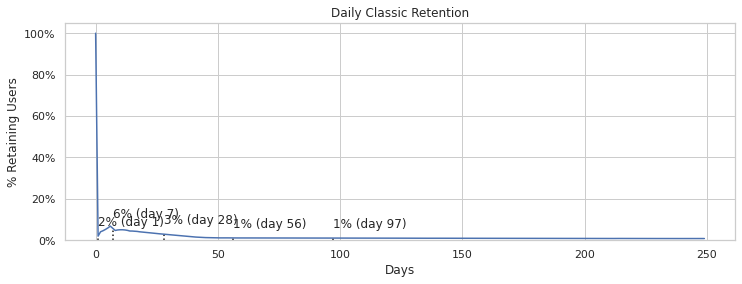

In [15]:
# Задаем параметры 
days = list(range(0, 250))
classic_retention = calculate_classic_retention(df, df_1, days)

plt_show(days, classic_retention, xs=[1, 7, 28, 56, 97], title='Daily Classic Retention')

# Rolling retention 


In [16]:
def calculate_rolling_retention(df: pd.DataFrame, df_1:pd.DataFrame, days: list) -> list:
  
    full_df = pd.merge(df_1, df, left_on='uid', right_on = 'uid')
   
    full_df['day'] = (full_df['auth_ts'] - full_df['reg_ts']).dt.days
    
    rolling_retention = []
    
    for day in days:
        users_with_rolling_day = full_df[full_df['day'] >= day]['uid'].unique()
        
        rolling_retention.append(len(users_with_rolling_day) / len(full_df['uid'].unique()))
    
    return rolling_retention

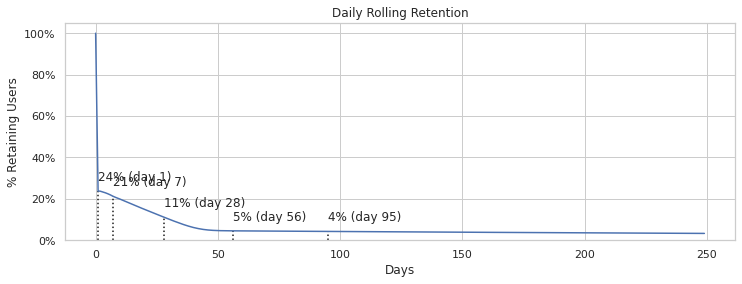

In [17]:
# Задаем параметры 
days = list(range(0, 250))
rolling_retention = calculate_rolling_retention(df, df_1, days)

plt_show(days, rolling_retention, xs=[1, 7, 28, 56, 95], title='Daily Rolling Retention')

# Full Retention 

In [18]:
def calculate_full_retention(df: pd.DataFrame, df_1: pd.DataFrame, days: list) -> list:
  
    full_df = pd.merge(df_1, df, left_on = 'uid', right_on = 'uid')
    
    full_df['day'] = (full_df['auth_ts'] - full_df['reg_ts']).dt.days
    
    full_retention = []
    
    for day in days:
        expected_days = set(range(1, day + 1))
        unique_days = full_df.groupby('uid')['day'].unique()

        full_retention_users = unique_days[unique_days.apply(lambda x: set(x) > expected_days)].index
        full_retention.append(len(full_retention_users) / len(full_df['uid'].unique()))
    
    return full_retention

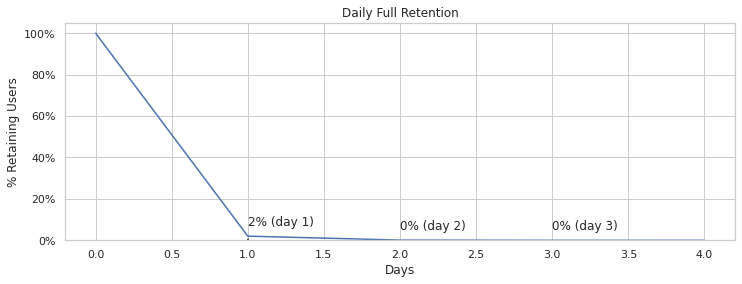

In [20]:
# Задаем параметры 
days = list(range(0, 5))
full_retention = calculate_full_retention(df, df_1, days)

plt_show(days, full_retention, xs=[1, 2, 3], title='Daily Full Retention')

Подводя итоги к Full Retention стоит сказать, что расчитали мы данный показатель правильно, так как у нас совпадает значение 1 дня со значением 1 дня в Classic Retention

# Задание 2 


In [4]:
# Считываем данные
df_ex2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-kugotov/final_project/Проект_1_Задание_2.csv', sep = ';')

In [5]:
df_ex2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [6]:
df_ex2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [7]:
# Создаем датафрейм для группы a
df_a = df_ex2.query("testgroup == 'a'")
df_a.reset_index(drop = True, inplace=True)
df_a

,user_id,revenue,testgroup
0,2,0,a
1,3,0,a
2,10,0,a
3,11,0,a
4,12,0,a
...,...,...,...
202098,404761,0,a
202099,404763,0,a
202100,404766,0,a
202101,404768,231,a


In [8]:
# Создаем датафрейм для группы b
df_b = df_ex2.query("testgroup == 'b'")
df_b.reset_index(drop = True, inplace=True)
df_b

,user_id,revenue,testgroup
0,1,0,b
1,4,0,b
2,5,0,b
3,6,0,b
4,7,0,b
...,...,...,...
202662,404762,0,b
202663,404764,0,b
202664,404765,0,b
202665,404767,0,b


# Конверсия


In [9]:
# Создаем столбец, где написано произведенна ли покупка
purchases = []
for i in df_a['revenue']:
    if i == 0:
        x = 'No'
    else:
        x = 'Yes'
    purchases.append(x)
df_a['purchase'] = purchases
df_a.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,revenue,testgroup,purchase
0,2,0,a,No
1,3,0,a,No
2,10,0,a,No
3,11,0,a,No
4,12,0,a,No


In [10]:
# Создаем столбец, где написано произведенна ли покупка
purchases = []
for i in df_b['revenue']:
    if i == 0:
        x = 'No'
    else:
        x = 'Yes'
    purchases.append(x)
df_b['purchase'] = purchases
df_b.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,revenue,testgroup,purchase
0,1,0,b,No
1,4,0,b,No
2,5,0,b,No
3,6,0,b,No
4,7,0,b,No


In [11]:
# Считаем конверсию для обеих групп
cr_a = df_a.query("purchase == 'Yes'").purchase.count() / df_a.purchase.count() * 100
cr_a.round(2)

0.95

In [12]:
cr_b = df_b.query("purchase == 'Yes'").purchase.count() / df_b.purchase.count() * 100
cr_b.round(2)

0.89

Конверсия в группе а больше, чем конверсия в группе b на 0.06%. Проверим стат. значимость с помощью хи-квадрата.

In [13]:
purchases = []
for i in df_ex2['revenue']:
    if i == 0:
        x = 'No'
    else:
        x = 'Yes'
    purchases.append(x)
df_ex2['purchase'] = purchases
df_ex2.head()

,user_id,revenue,testgroup,purchase
0,1,0,b,No
1,2,0,a,No
2,3,0,a,No
3,4,0,b,No
4,5,0,b,No


In [14]:
contingency_table = pd.crosstab(df_ex2['testgroup'], df_ex2['purchase'])
print(contingency_table)

purchase       No   Yes
testgroup              
a          200175  1928
b          200862  1805


In [15]:
chi2, p, dof, expected = ss.chi2_contingency(contingency_table)
print(f"χ²: {chi2}, p-значение: {p}")

χ²: 4.374729521260405, p-значение: 0.03647561892312613


Можем сделать вывод, что нулевая гипотеза отклоняется, есть статистически значимое влияние. 
Наборы акционных предложений для группы а оказал влияние на желание пользователей совершать покупки.

# ARPU

In [16]:
round(df_ex2 \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

,testgroup,revenue
0,a,25.41
1,b,26.75


Можно сделать вывод о том, что средняя выручка на одного пользователя больше в группе b (как и было написано в задании).

In [18]:
alpha = 0.05
p = ss.ttest_ind(df_ex2.query("testgroup == 'a'")['revenue'], df_ex2.query("testgroup == 'b'")['revenue'], 
                    equal_var = False)[1]
print(p)

0.5329647014130866


Так как не отклоняется нулевая гипотеза, статистически значимой разницы между ARPU группы а и группы b нет.

Дальше мы будем сравнивать группы a и b с помощью т-теста, так как даже несмотря на большие размеры выборок, данный метод остается эффективным инструментом для оценки различий между средними значениями. Когда размер выборок велик, по теоретическим закономерностям, распределение средних стремится к нормальному, что делает применение т-теста оправданным. Он также позволяет учитывать возможные отклонения в данных и обеспечивает достаточную мощность для выявления значимых различий. Важно отметить, что даже при больших выборках т-тест помогает контролировать ошибки 1 рода, что важно в данном случае.

# ARRPU


In [20]:
round(df_ex2 \
    .query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

,testgroup,revenue
0,a,2664.00
1,b,3003.66


По показателю ARRPU группа b больше группы a. 

In [24]:
alpha = 0.05
p = ss.ttest_ind(df_ex2.query("testgroup == 'a' & revenue > 0")['revenue'], df_ex2.query("testgroup == 'b' & revenue > 0")['revenue'], 
                    equal_var = False)[1]
print(p)

0.10020780398916015


Так как не отклоняется нулевая гипотеза, статистически значимой разницы между ARPU группы а и группы b нет.

# Распределение выручки по группам

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'group b')

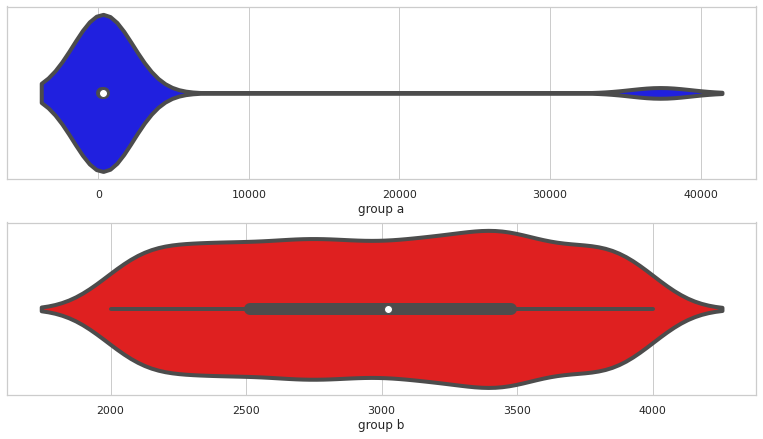

In [34]:
# Создаем график для отражения распределия выручки
fig = plt.figure(figsize = (13, 3))

ax0 = fig.add_axes([0, 0, 0.8, 0.8])
ax1 = fig.add_axes([0, -1, 0.8, 0.8])

sns.violinplot(df_ex2.query("testgroup == 'a' & revenue > 0")['revenue'],
               ax = ax0,
               color = 'blue',
               edgecolor = 'black',
               linewidth = 4)

sns.violinplot(df_ex2.query("testgroup == 'b' & revenue > 0")['revenue'],
               ax = ax1,
               color = 'red',
               edgecolor = 'black',
               linewidth = 4)

ax0.set_xlabel('group a')
ax1.set_xlabel('group b')

Если смотреть на распределение выручки, то можно сказать, что в группе b распределение более равномерно по сравнению с a. В группе a присутствуют очень высокие показатели revenue.

# Выводы 

- Если смотреть на распределение выручки, то можно сказать, что в группе b распределение более равномерно по сравнению с a. В группе a присутствуют очень высокие показатели revenue.
- Конверсия в группе а больше, чем конверсия в группе b на 0.06%.  Есть статистически значимое влияние. Наборы акционных предложений для группы а оказал влияние на желание пользователей совершать покупки.
- Можно сделать вывод о том, что средняя выручка на одного пользователя больше в группе b (как и было написано в задании). Так как не отклоняется нулевая гипотеза, статистически значимой разницы между ARPU группы а и группы b нет.
- По показателю ARRPU группа b больше группы a. Так как не отклоняется нулевая гипотеза, статистически значимой разницы между ARPU группы а и группы b нет.


С учетом полученных результатов трудно сделать окончательный вывод. Необходимо уточнить задачи, которые стоят перед командой. С одной стороны, разница в акционных предложениях влияет на конверсию, и в группе А она выше, хотя ARPU и ARPPU в этой группе ниже, но их различия не являются статистически значимыми. С другой стороны, вызывает настороженность поведение пользователей в группе А, большая часть которых приносит меньше дохода по сравнению с группой Б, и только около 0,06% пользователей генерируют значительно больший доход

**Исходя из данных, которые у нас есть, по моему мнению, стоит реализовать акционное предложение (a), так как в сравнениях ARPU и ARPPU не было выявлено стат. значимых различий, а в конверсии мы как раз наблюдаем такое изменение в группе a.**

# Задание 3


Отвечая на вопрос, c помощью каких метрик можно оценить результаты последнего прошедшего события в игре Plants & Gardens, то я бы выделил следующие метрики:

    * Retention Rate - процент возврата игроков во время ивента.
    * DAU и MAU (если ивент длится больше месяца), количество уникальных пользователей за день и месяц соответственно.
    * ARPU и ARPPU - если у нас есть платные опции, такие как боевой пропуск, лотереи за реальные деньги и прочее.
    * ASL - продолжительность сессий.
    * Метрика виральности - означает коэффицент привлечения других пользователей.
    * Intimacy - привлечение, или отвращение пользователя. Измеряется рейтингами удовлетворенности, анализом настроений в блогах, комментариями, опросами.
    * CTR - это показатель кликабельности, который помогает оценить эффективность рекламной кампании внутриигрового события.
    
Далее, отвечая на второй вопрос, который связан с усложнением механики, следует сделать следущющие шаги:
    1. Оценить воронку конверсии пользователей от усложнения механики, анализируем к чему привели шаги, каким образом меняется количество пользователей от шага к шагу. 
    2. Retention и Rolling Retention. Необходимо выделить несколько когорт и сравнить retention этих групп.
    3. Провести A/B тест, то есть сравнить период до изменения механики и после изменения.
    4. Также стоит проверить статистически ли значимо измененеие механики.
Подводя итоги по второму вопросу, думаю что анализировать метрику CTR будет не эффективно.